In [1]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import pandas as pd 
import numpy as np 

from metrics import accuracy_report

In [2]:
import re 
def barplot(csv_groups, level, x_name, hue_name, title=None, ax=None, filtered = False, ignore_first_only = False):
    # consolidate data from different csvs 
    all_dfs = {g:[] for g in csv_groups.keys()}
    for group, csvs in csv_groups.items():
        for csv in csvs:
            df = pd.read_csv(csv)
            # print(csv, len(df))
            all_dfs[group].append(df)

    reports = {g: [accuracy_report(df, ignore_first_only, total_only=True) for df in dfs] for g, dfs in all_dfs.items()}
    # data = [report[level] for report in reports]
    data = {g: [report[level] for report in group_reports] for g, group_reports in reports.items()}
    df_to_plot = pd.DataFrame(columns=["model", "acc", "type"], dtype=object)
    for group, group_data in data.items():
        for i, data_dict in enumerate(group_data):
            df = all_dfs[group][i]
            model_name = df['model'][0]
            model_name = re.sub("_", "-", model_name)
            model_name = re.sub("-qa", "", model_name)
            if type(data_dict) == dict:
                for k, v in data_dict.items():
                    if filtered: 
                        acc = float(v[2])
                    else:
                        acc = float(v[0])
                    type_name = k
                    df_to_plot = df_to_plot.append({"model": model_name, "acc": acc, "type": type_name, "group": group}, ignore_index=True)
            else:
                # v, __, __, __ = data_dict
                v= data_dict
                if filtered: 
                    acc = float(v[2])
                else:
                    acc = float(v[0])
                type_name = "total"
                df_to_plot = df_to_plot.append({"model": model_name, "acc": acc, "type": type_name, "group": group}, ignore_index=True)

    g = sns.catplot(data = df_to_plot, kind='bar', x = x_name, y = 'acc', hue = hue_name, palette="colorblind", col="group")
    g.set(ylim=(0, 1.0))

    # g.ax.set_ylim(top=1.0, bottom=0.0)
    # [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
    if title is not None:
        g.fig.suptitle(title)
    for ax_line in g.axes:
        for ax in ax_line:
            xs = (-0.4, 0.4)
            ys = (0.5, 0.5)
            ax.plot(xs, ys, "-")
    return g 

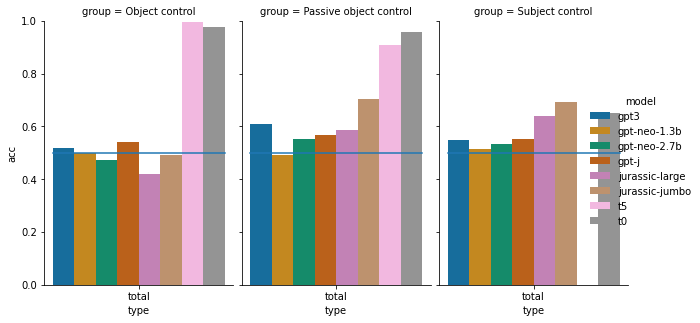

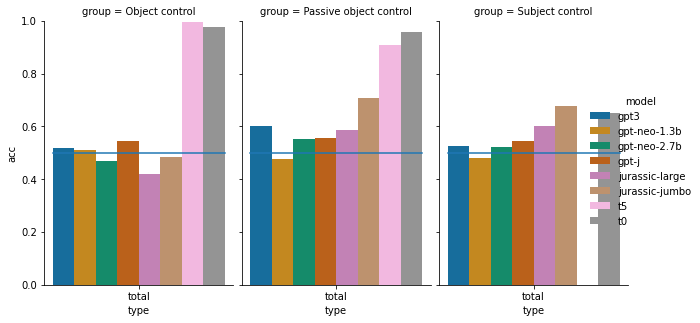

In [3]:


oc_csvs=["../results_to_plot/gpt_object_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_object_control.csv", 
     "../results_to_plot/gpt_neo_2.7b_object_control.csv", 
     "../results_to_plot/gpt_j_object_control.csv", 
     "../results_to_plot/jurassic_object_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_object_control_swap_names.csv", 
     "../results_to_plot/t5_object_control.csv",
     "../results_to_plot/t0_object_control.csv"]

sc_csvs=["../results_to_plot/gpt_subject_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_subject_control.csv",
     "../results_to_plot/gpt_neo_2.7b_subject_control.csv", 
     "../results_to_plot/gpt_j_subject_control.csv",
     "../results_to_plot/jurassic_subject_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results_to_plot/t5_subject_control.csv",
     "../results_to_plot/t0_subject_control.csv"]

poc_csvs=["../results_to_plot/gpt_passive_object_control_swap_names.csv", 
     "../results_to_plot/gpt_neo_1.3B_passive_object_control.csv",
     "../results_to_plot/gpt_neo_2.7b_passive_object_control.csv",
     "../results_to_plot/gpt_j_passive_object_control.csv",
     "../results_to_plot/jurassic_passive_object_control_swap_names.csv", 
     "../results_to_plot/jurassic_jumbo_passive_object_control_swap_names.csv", 
     "../results_to_plot/t5_passive_object_control.csv",
     "../results_to_plot/t0_passive_object_control.csv"]

csv_data = {"Object control": oc_csvs, "Passive object control": poc_csvs, "Subject control": sc_csvs}
# csv_data = {"Object control": [oc_csvs[3]]}
# g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=False)
# g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True)
g.figure.set_size_inches(9.5, 4.5)

g = barplot(csv_data, level="total", x_name = "type", hue_name = "model", filtered=True, ignore_first_only=True)
g.figure.set_size_inches(9.5, 4.5)

sns.despine()

In [ ]:
# Recompute Object Control with Names
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_object_control_swap_names.csv", 
     "../results/gpt_neo_1.3b_object_control.csv", 
     "../results/gpt_neo_2.7b_object_control.csv", 
     "../results/gpt_j_object_control.csv", 
     "../results/jurassic_object_control_swap_names.csv",
     "../results/jurassic_jumbo_object_control_swap_names.csv", 
     "../results/t5_object_control.csv",
     "../results/t0_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "object-control", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot/{filename}")


In [ ]:
# Recompute Passive Object Control with Names 
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_passive_object_control_swap_names.csv", 
     "../results/gpt_neo_1.3B_passive_object_control.csv", 
     "../results/gpt_neo_2.7b_passive_object_control.csv", 
     "../results/gpt_j_passive_object_control.csv", 
     "../results/jurassic_passive_object_control_swap_names.csv",
     "../results/jurassic_jumbo_passive_object_control_swap_names.csv", 
     "../results/t5_passive_object_control.csv",
     "../results/t0_passive_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "object-control-passive", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot/{filename}")


In [ ]:
#  Recompute Subject Control With Names
import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames.json"))
csvs = ["../results/gpt_subject_control_swap_names.csv", 
     "../results/gpt_neo_1.3B_subject_control.csv", 
     "../results/gpt_neo_2.7b_subject_control.csv", 
     "../results/gpt_j_subject_control.csv", 
     "../results/jurassic_subject_control_swap_names.csv",
     "../results/jurassic_jumbo_subject_control_swap_names.csv", 
     "../results/t5_subject_control.csv",
     "../results/t0_subject_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5", "t0"]
for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "subject-control", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot/{filename}")


## Professions

In [ ]:
# recompute object control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_object_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_object_control.csv", 
     "../results_profession/gpt_neo_2.7b_object_control.csv", 
     "../results_profession/gpt_j_object_control.csv", 
     "../results_profession/jurassic_object_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_object_control.csv", 
     "../results_profession/t5_object_control.csv",
     "../results_profession/t0_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5", "t0"]
# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt_j", "t5_qa", "t0"]
for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "object-control", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot_profession/{filename}")


In [ ]:
# recompute subject control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_subject_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_subject_control.csv", 
     "../results_profession/gpt_neo_2.7b_subject_control.csv", 
     "../results_profession/gpt_j_subject_control.csv", 
     "../results_profession/jurassic_subject_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_subject_control.csv", 
     "../results_profession/t5_subject_control.csv",
     "../results_profession/t0_subject_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]
# names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt_j", "t5_qa", "t0"]
for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "subject-control", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot_profession/{filename}")


In [ ]:
# recompute passive object control with professions 

import json 
import pathlib 
from experiment import Experiment
prompt=None
wrapper_fxn=None
nicknames = json.load(open("../data/nicknames_professions.json"))
csvs = [
     "../results_profession/gpt_passive_object_control_swap_names.csv", 
     "../results_profession/gpt_neo_1.3b_passive_object_control.csv", 
     "../results_profession/gpt_neo_2.7b_passive_object_control.csv", 
     "../results_profession/gpt_j_passive_object_control.csv", 
     "../results_profession/jurassic_passive_object_control_swap_names.csv",
     "../results_profession/jurassic_jumbo_passive_object_control.csv", 
     "../results_profession/t5_passive_object_control.csv",
     "../results_profession/t0_passive_object_control.csv"]

names = ["gpt", "gpt-neo-1.3b", "gpt-neo-2.7b", "gpt-j", "jurassic-large", "jurassic-jumbo", "t5_qa", "t0"]

for csv, name in zip(csvs, names): 
    exp  = Experiment(name, "object-control", prompt, wrapper_fxn, 1, None)
    filename = pathlib.Path(csv).name
    exp.recover(csv)
    exp.recompute(nicknames)
    df = exp.format_results()
    df.to_csv(f"../results_to_plot_profession/{filename}")


In [ ]:

oc_csvs=[
     "../results_to_plot_profession/gpt_object_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_object_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_object_control.csv", 
     "../results_to_plot_profession/gpt_j_object_control.csv", 
     "../results_to_plot_profession/jurassic_object_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_object_control.csv", 
     "../results_to_plot_profession/t5_object_control.csv",
     "../results_to_plot_profession/t0_object_control.csv"]

sc_csvs=[
     "../results_to_plot_profession/gpt_subject_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_subject_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_subject_control.csv", 
     "../results_to_plot_profession/gpt_j_subject_control.csv", 
     "../results_to_plot_profession/jurassic_subject_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_subject_control.csv", 
     "../results_to_plot_profession/t5_subject_control.csv",
     "../results_to_plot_profession/t0_subject_control.csv"]

poc_csvs=[
     "../results_to_plot_profession/gpt_object_control_swap_names.csv", 
     "../results_to_plot_profession/gpt_neo_1.3B_passive_object_control.csv", 
     "../results_to_plot_profession/gpt_neo_2.7b_passive_object_control.csv", 
     "../results_to_plot_profession/gpt_j_passive_object_control.csv", 
     "../results_to_plot_profession/jurassic_passive_object_control_swap_names.csv", 
     "../results_to_plot_profession/jurassic_jumbo_passive_object_control.csv",
     "../results_to_plot_profession/t5_passive_object_control.csv",
     "../results_to_plot_profession/t0_passive_object_control.csv"]

csvs = {"object control": oc_csvs, "passive object control": poc_csvs, "subject control": sc_csvs}

g = barplot(csvs, level="total", x_name = "type", hue_name = "model", title = "", filtered=False)
g.figure.set_size_inches(8.5, 4.5)

g = barplot(csvs, level="total", x_name = "type", hue_name = "model", title = "", filtered=True)
g.figure.set_size_inches(8.5, 4.5)
sns.despine()
